In [ ]:
import os

RES_DIR = '/content/data'
FRAMES_DIR = os.path.join(RES_DIR, 'images')
!rm -rf $RES_DIR
!mkdir $RES_DIR
!mkdir $FRAMES_DIR

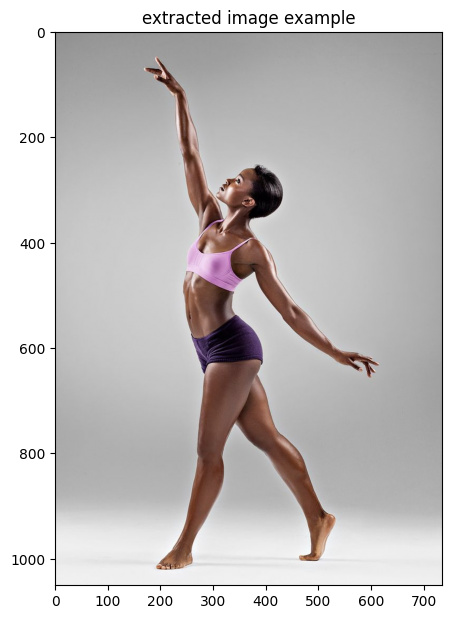

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_img(img_path):

  return np.asarray(Image.open(img_path))/255

test_img_path = os.path.join(FRAMES_DIR, os.listdir(FRAMES_DIR)[0])

test_img = load_img(test_img_path)

plt.figure(figsize=(5, 10))
plt.title("extracted image example")
plt.imshow(test_img)

## Extract 2D body keypoints with OpenPose



In [ ]:
############################################## (Important; manually (2024 8/30))
## Download openpose checkpoint three files
# (1) hand: https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_102000.caffemodel
# (2) pose/body_25: https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_584000.caffemodel
# (3) face: https://www.kaggle.com/datasets/changethetuneman/openpose-model?select=pose_iter_116000.caffemodel

# move below folders
%cd /content/
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir /content/gdrive/MyDrive/openpose
!mkdir /content/gdrive/MyDrive/openpose/hand # 102000.caffemodel
!mkdir /content/gdrive/MyDrive/openpose/pose # 584000.caffemodel
!mkdir /content/gdrive/MyDrive/openpose/face # 116000.caffemodel

/content
Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose/hand’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose/pose’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/openpose/face’: File exists


In [ ]:
%cd /content
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

  # clone openpose
  !git clone -q --depth 1 $git_repo_url

  # download models (2024 ~8/29 not working)
  #!wget -O /content/openpose/models/hand/pose_iter_102000.caffemodel https://polybox.ethz.ch/index.php/s/Oim76cuqrDVbdxm/download
  #!wget -O /content/openpose/models/pose/body_25/pose_iter_584000.caffemodel https://polybox.ethz.ch/index.php/s/m5NQAhd7ukVPRoL/download
  #!wget -O /content/openpose/models/face/pose_iter_116000.caffemodel https://polybox.ethz.ch/index.php/s/cEaF1FTpKjjJZbH/download

  # (new 2024 8/30) download models
  %cd /content/

  HAND_ZIP_PATH = '/content/gdrive/MyDrive/openpose/hand/pose_iter_102000.caffemodel.zip'
  POSE_ZIP_PATH = '/content/gdrive/MyDrive/openpose/pose/pose_iter_584000.caffemodel.zip'
  FACE_ZIP_PATH = '/content/gdrive/MyDrive/openpose/face/pose_iter_116000.caffemodel.zip'

  HAND_MODEL_PATH = '/content/openpose/models/hand'
  #!mkdir $HAND_ZIP_PATH
  !unzip -n $HAND_ZIP_PATH -d $HAND_MODEL_PATH

  POSE_MODEL_PATH = '/content/openpose/models/pose/body_25'
  #!mkdir $POSE_ZIP_PATH
  !unzip -n $POSE_ZIP_PATH -d $POSE_MODEL_PATH

  FACE_MODEL_PATH = '/content/openpose/models/face'
  #!mkdir $FACE_ZIP_PATH
  !unzip -n $FACE_ZIP_PATH -d $FACE_MODEL_PATH
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt

  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

  # install python dependencies
  !pip install -q youtube-dl

  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

/content
/content
Archive:  /content/gdrive/MyDrive/openpose/hand/pose_iter_102000.caffemodel.zip
  inflating: /content/openpose/models/hand/pose_iter_102000.caffemodel  
Archive:  /content/gdrive/MyDrive/openpose/pose/pose_iter_584000.caffemodel.zip
  inflating: /content/openpose/models/pose/body_25/pose_iter_584000.caffemodel  
Archive:  /content/gdrive/MyDrive/openpose/face/pose_iter_116000.caffemodel.zip
  inflating: /content/openpose/models/face/pose_iter_116000.caffemodel  
Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpa

/content
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 5.955235 seconds.


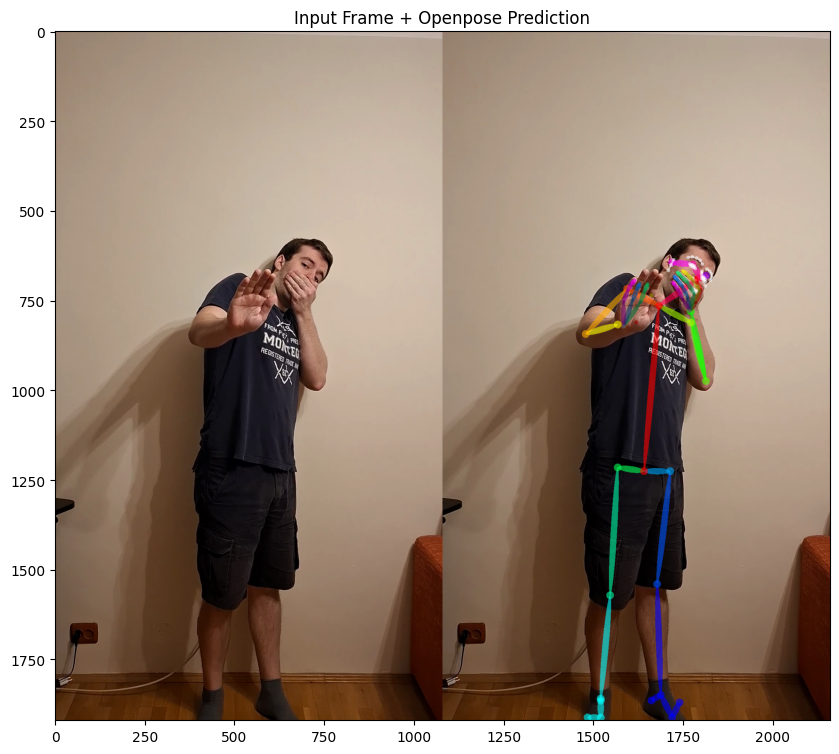

In [ ]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np


%cd /content
KEYPOINTS_DIR = os.path.join(RES_DIR, 'keypoints')
OPENPOSE_IMAGES_DIR = os.path.join(RES_DIR, 'openpose_images')
!mkdir $KEYPOINTS_DIR
!mkdir $OPENPOSE_IMAGES_DIR

!cd openpose && ./build/examples/openpose/openpose.bin --image_dir /content/data/images --write_json $KEYPOINTS_DIR --face --hand --display 0 --write_images $OPENPOSE_IMAGES_DIR

input_img_path = os.path.join(FRAMES_DIR, sorted(os.listdir(FRAMES_DIR))[0])
openpose_img_path = os.path.join(OPENPOSE_IMAGES_DIR, sorted(os.listdir(OPENPOSE_IMAGES_DIR))[0])

test_img = load_img(input_img_path)
open_pose_img = load_img(openpose_img_path)

plt.figure(figsize=(10, 10))
plt.title("Input Frame + Openpose Prediction")
plt.imshow(np.concatenate([test_img, open_pose_img], 1))

In [ ]:
%cd /content
!pip install chumpy
!pip install smplx[all]
!git clone https://github.com/vchoutas/smplx
%cd smplx
!python setup.py install

#vposer
!pip install git+https://github.com/nghorbani/configer
!pip install git+https://github.com/nghorbani/human_body_prior
#!pip install git+https://github.com/sergeyprokudin/human_body_prior

#!pip install torch==1.1.0
%cd /content
#!git clone https://github.com/sergeyprokudin/smplify-x
!git clone https://github.com/KyujinHan/Smplify-X-Perfect-Implementation
%cd /content/Smplify-X-Perfect-Implementation
!pip install -r requirements.txt # Error is okay. Just pass.

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58264 sha256=d19ff8b83ebdfe05c22143ece03d889e596760d01c133962ba814f2ea96deeae
  Stored in directory: /root/.cache/pip/wheels/e0/c1/ef/29ba7be03653a29ef6f2c3e1956d6c4d8877f2b243af411db1
Successfully built chumpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.6/696.6 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.6/936.6 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.0 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl si

In [ ]:
%cd /content/
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir /content/gdrive/MyDrive/smplify-x/
!mkdir /content/gdrive/MyDrive/smplify-x/vposer
!mkdir /content/gdrive/MyDrive/smplify-x/smplx

SMPLX_ZIP_PATH = '/content/gdrive/MyDrive/smplify-x/smplx/models_smplx_v1_1.zip'
VPOSER_ZIP_PATH = '/content/gdrive/MyDrive/smplify-x/vposer/V02_05.zip'

SMPLX_MODEL_PATH = '/content/smplx'
!mkdir $SMPLX_MODEL_PATH
!unzip -n $SMPLX_ZIP_PATH -d $SMPLX_MODEL_PATH
VPOSER_MODEL_PATH = '/content/vposer'
!mkdir $VPOSER_MODEL_PATH
!unzip -n $VPOSER_ZIP_PATH -d $VPOSER_MODEL_PATH

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/MyDrive/smplify-x/’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/smplify-x/vposer’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/smplify-x/smplx’: File exists
mkdir: cannot create directory ‘/content/smplx’: File exists
Archive:  /content/gdrive/MyDrive/smplify-x/smplx/models_smplx_v1_1.zip
   creating: /content/smplx/models/
  inflating: /content/smplx/__MACOSX/._models  
   creating: /content/smplx/models/smplx/
  inflating: /content/smplx/__MACOSX/models/._smplx  
  inflating: /content/smplx/models/.DS_Store  
  inflating: /content/smplx/__MACOSX/models/._.DS_Store  
  inflating: /content/smplx/models/smplx/SMPLX_FEMALE.pkl  
  inflating: /content/smplx/__MACOSX/models/smplx/._SMPLX_FEMALE.pkl  
  inflating: /content/smplx/models/smplx/SMPLX_FEMALE.npz

In [ ]:
# pop-up is ok, click cancel
!pip install configargparse
!pip install omegaconf
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=14b50de3151da637cdd26921be58d1e66f151c5be78d637af409b0ff8aaf8510
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
gender = 'male' #@param ["neutral", "female", "male"]

!rm -rf /content/data/smplifyx_results
%cd /content/Smplify-X-Perfect-Implementation
!git pull origin

!python smplifyx/main.py --config cfg_files/fit_smplx.yaml \
    --data_folder  /content/data \
    --output_folder /content/data/smplifyx_results \
    --visualize=True \
    --gender=$gender \
    --model_folder /content/smplx/models \
    --vposer_ckpt /content/vposer/V02_05\
    --part_segm_fn smplx_parts_segm.pkl

/content/Smplify-X-Perfect-Implementation
Already up to date.
Processing: /content/data/images/frame4.png
/content/vposer/V02_05
/usr/local/lib/python3.10/dist-packages/human_body_prior/tools/model_loader.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. P

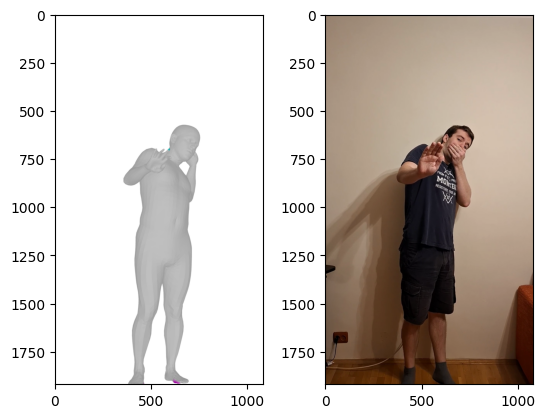

In [ ]:
## image
import matplotlib.pyplot as plt
from PIL import Image
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

img1 = Image.open('/content/data/smplifyx_results/rendered_smplifyx_meshes/00000.png')
img2 = Image.open('/content/data/images/frame4.png')
ax1.imshow(img1)
ax2.imshow(img2)